# Install necessary packages

In [38]:
!pip install imblearn

In [39]:
!pip install tensorflow

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.model_selection import GridSearchCV, train_test_split



ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import warnings
warnings.filterwarnings("ignore")


# Load Dataset

In [7]:
# Load the dataset
data = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")

# Display the first few rows of the dataset to understand its structure
data.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# EDA

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [44]:
# Drop the 'id' column as it's not useful for prediction
data = data.drop('id', axis=1)

In [45]:
missing_values = data.isnull().sum()

print(missing_values)


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [46]:
# Impute missing values in 'bmi' with the median of the column
imputer = SimpleImputer(strategy='median')
data['bmi'] = imputer.fit_transform(data[['bmi']])

In [47]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [48]:
# Label encoding binary columns
label_encoder = LabelEncoder()
binary_columns = ['ever_married', 'Residence_type']
for col in binary_columns:
    data[col] = label_encoder.fit_transform(data[col])  # Overwriting the original columns

# One-hot encoding for other nominal categories
data = pd.get_dummies(data, columns=['gender', 'work_type', 'smoking_status'], drop_first=True)

In [49]:
data.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male',
       'gender_Other', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [50]:
data.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,1,228.69,36.6,1,True,False,False,True,False,False,True,False,False
1,61.0,0,0,1,0,202.21,28.1,1,False,False,False,False,True,False,False,True,False
2,80.0,0,1,1,0,105.92,32.5,1,True,False,False,True,False,False,False,True,False
3,49.0,0,0,1,1,171.23,34.4,1,False,False,False,True,False,False,False,False,True
4,79.0,1,0,1,0,174.12,24.0,1,False,False,False,False,True,False,False,True,False


In [51]:
stroke_count = data['stroke'].value_counts()
print(stroke_count)


stroke
0    4861
1     249
Name: count, dtype: int64


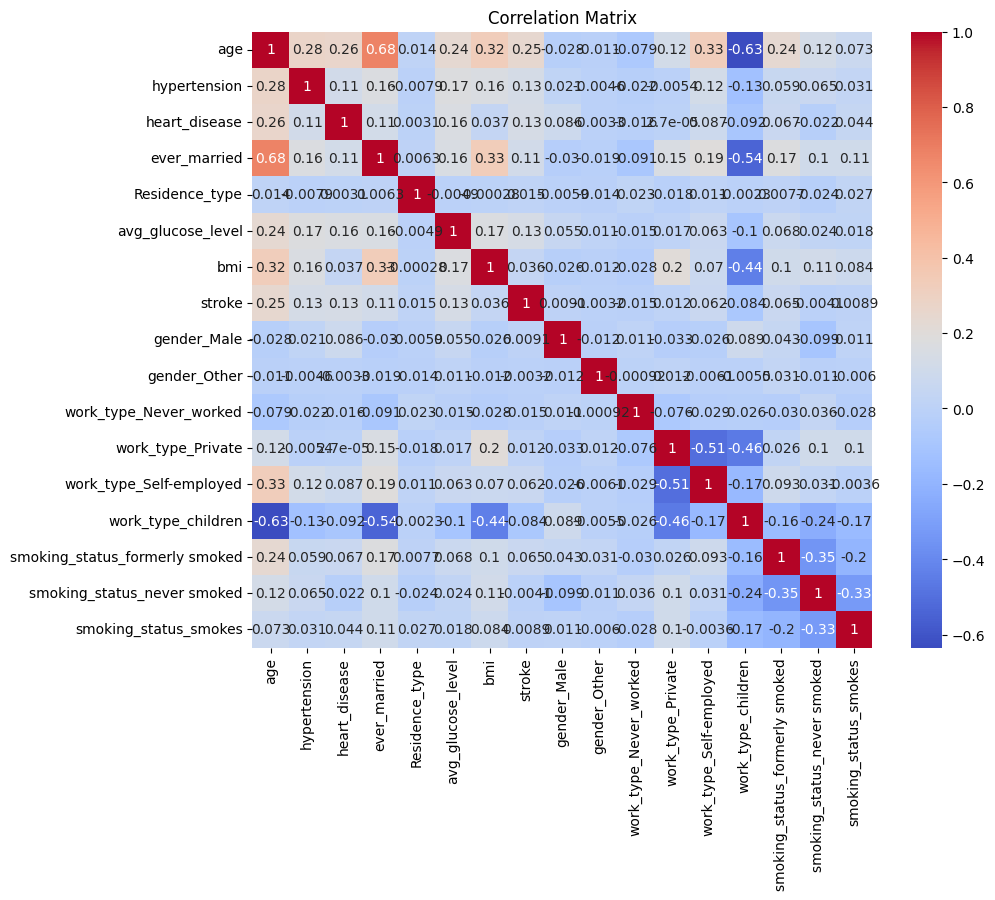

In [52]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


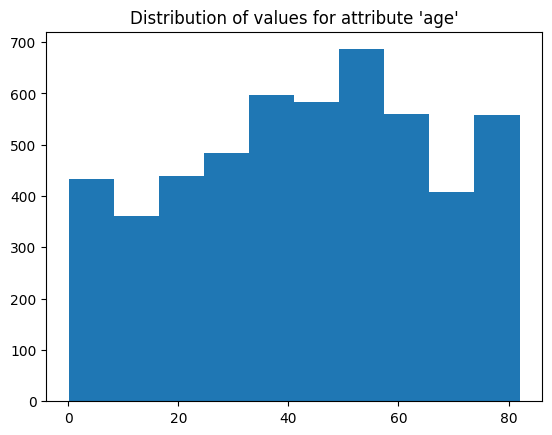

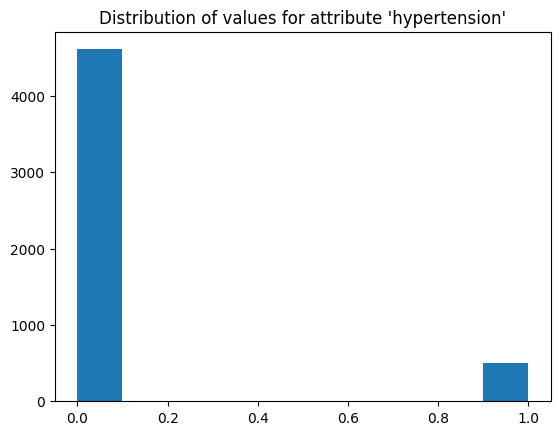

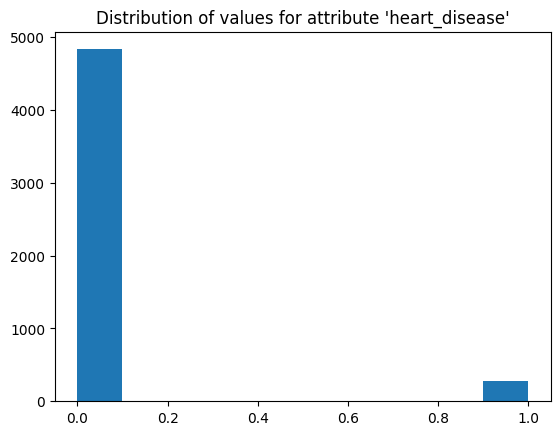

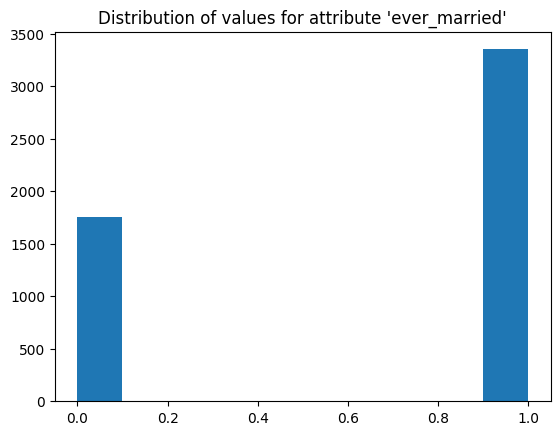

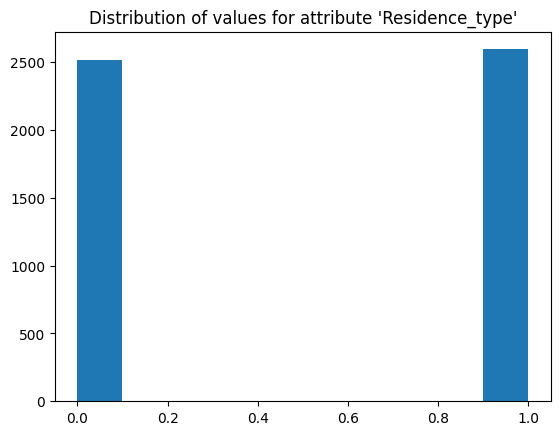

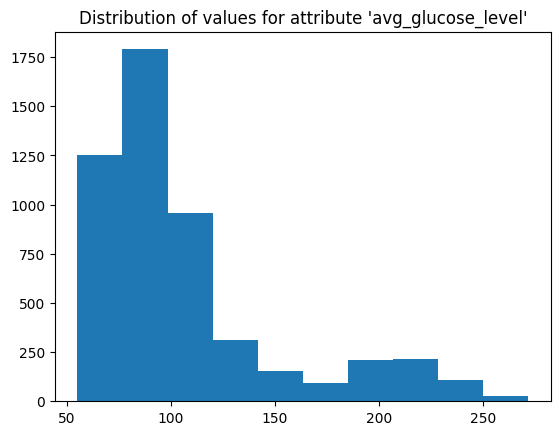

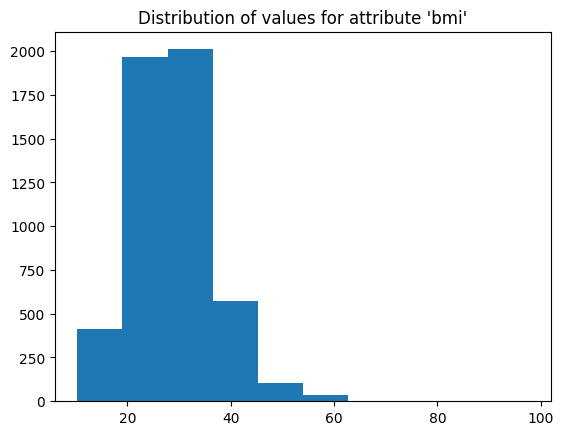

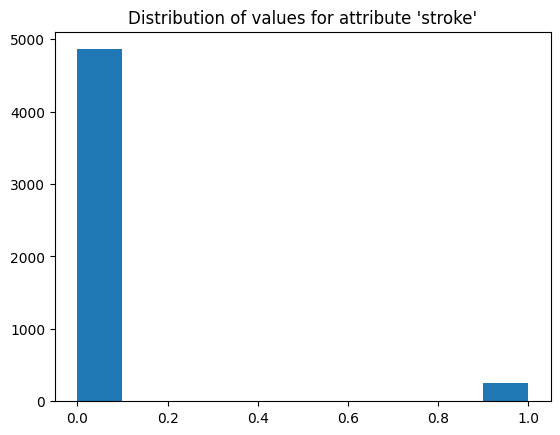

In [53]:
numeric_data = data.select_dtypes(include=["int64", "float64"])
attribute_names = numeric_data.columns

for attribute_name in attribute_names:
    plt.figure()
    plt.hist(numeric_data[attribute_name])
    plt.title(f"Distribution of values for attribute '{attribute_name}'")
    plt.show()

**Age Distribution:** The first chart shows a fairly uniform distribution of ages, with a slight increase around the 50-60 age bracket. This could be indicative of a population with a wide range of ages represented in the data, which is less likely to be from a specific group (like school students or retirees) and more likely to be representative of a general population.

**Hypertension:** The distribution indicates that a large majority of the individuals in the dataset do not have hypertension, with only a small fraction having this condition.

**Heart Disease:** Similarly to hypertension, the chart for heart disease indicates that few individuals have heart disease compared to those who do not.

**Marital Status (Ever Married):** This chart suggests that most individuals in the dataset have been married at least once.

**Residence Type:** The data seems to be almost evenly split between two types of residence, possibly urban and rural.

**Average Glucose Level:** This histogram shows a right-skewed distribution, meaning most individuals have glucose levels on the lower side, but there is a long tail towards the higher glucose levels. The peak is around the 75-100 mg/dL range, which is considered normal.

**BMI:** This histogram also appears right-skewed, with the majority of individuals having a BMI in the range considered normal or overweight (around 25-30), but fewer individuals in the underweight and obese categories.

**Stroke:** Like hypertension and heart disease, the vast majority of individuals have not experienced a stroke.

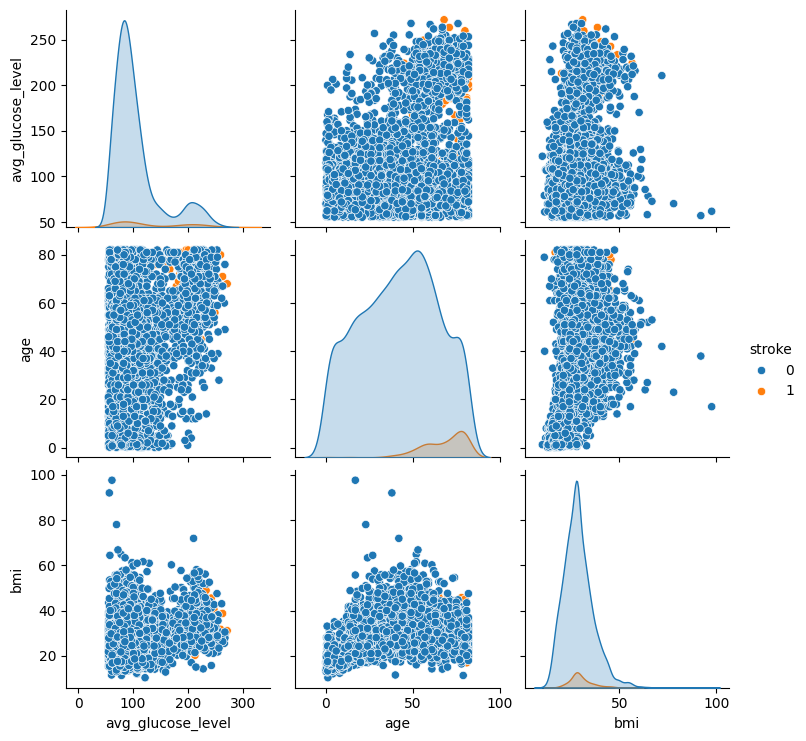

In [54]:
sns.pairplot(data[['avg_glucose_level','age','bmi','stroke']], hue='stroke')
plt.show()


**Average Glucose Level:** The distribution of average glucose levels is skewed right, with a peak in the normal range, but some individuals have very high levels. When compared to strokes, higher glucose levels appear to have more instances of strokes (orange dots).

**Age:** The age distribution is broad with a slight skew to the right, suggesting a population that includes elderly individuals. The scatter plots indicate a clear trend: the likelihood of stroke increases with age.

**BMI:** The BMI distribution is also right-skewed, with most data points falling in the range considered normal or overweight. The relationship between BMI and stroke is not as clear from this plot, but there are some instances of strokes across all BMI values.

**Relationship Between Variables:**

**Age and Average Glucose Level:** There is no distinct pattern or correlation visible in the scatter plot between age and average glucose level. This suggests that within this dataset, there is no clear trend between age and glucose level.

**Age and BMI:** Again, there is no clear correlation between age and BMI from the scatter plot.

**Average Glucose Level and BMI:** The scatter plot does not show a clear correlation between average glucose levels and BMI.

**Stroke Occurrences:**

**Strokes and Average Glucose Level:** There is a noticeable cluster of strokes (orange dots) at higher glucose levels.

**Strokes and Age:** Strokes are more common in older age groups.

**Strokes and BMI:** Strokes are scattered across the range of BMI, indicating that within this dataset, BMI is not a clear-cut predictor for strokes.

In [55]:
# Separate features and target variable
X = data.drop('stroke', axis=1)
y = data['stroke']

In [56]:
X.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'gender_Male',
       'gender_Other', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [57]:
y.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

As we can see the data is imbalanced. we will balance it in further steps.

# Function for calculation of metrics using confusion matrix

In [58]:
def calculate_metrics_from_cm(tp, tn, fp, fn):
    # Calculate basic metrics directly from confusion matrix values
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    sensitivity = recall  # Which is the same as recall
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    error_rate = 1 - accuracy
    bacc = (sensitivity + specificity) / 2  # Balanced accuracy

    # True Skill Statistic (TSS)
    tss = sensitivity + specificity - 1

    # Heidke Skill Score (HSS)
    hss_denominator = ((tp + fn) * (fn + tn)) + ((tp + fp) * (fp + tn))
    hss = (2 * ((tp * tn) - (fn * fp)) / hss_denominator) if hss_denominator != 0 else 0

    # Placeholder values for Brier score, AUC, and other complex metrics
    #brier_score = 'To be calculated'
    #auc = 'To be calculated'
    #acc_by_package_fn = 'To be calculated'

    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'TPR': recall, 'TNR': specificity, 'FPR': 1 - specificity, 'FNR': 1 - recall,
        'Precision': precision, 'F1_measure': f1, 'Accuracy': accuracy, 'Error_rate': error_rate,
        'BACC': bacc, 'TSS': tss, 'HSS': hss
    }

# Finding Best parameters for models using GridSearchCV

In [59]:
# Define model configurations and parameter grids
models = {
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [50,60,70,80,90,100],
            'classifier__min_samples_split': [2, 5, 10],
        }
    },
    "SVM": {
        'model': SVC(probability=True, random_state=42, max_iter=1000),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
        }
    }
}

# Setup the pipeline with a placeholder for the classifier
pipeline = ImPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', None)  # Placeholder that will be replaced in the loop
])

# Iterate over each model configuration
for name, model_info in models.items():
    # Update the classifier in the pipeline
    pipeline.set_params(classifier=model_info['model'])

    # Setup GridSearchCV
    grid = GridSearchCV(pipeline, model_info['params'], cv=10, scoring='accuracy', verbose=1)
    grid.fit(X, y)

    # Output results
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best cross-validation score for {name}: {grid.best_score_}")

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters for Random Forest: {'classifier__min_samples_split': 5, 'classifier__n_estimators': 60}
Best cross-validation score for Random Forest: 0.9183953033268102
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best parameters for SVM: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best cross-validation score for SVM: 0.8377690802348337


# Function to create LSTM model

In [60]:
import tensorflow as tf
# Function to create LSTM model
def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(20, return_sequences=False, input_shape=input_shape),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model Training with Kfold

In [61]:
# Define KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize dictionary to store metrics for each model
model_metrics = {
    "Random Forest": [],
    "SVM": [],
    "LSTM": []
}

metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR','Precision','F1_measure', 'Accuracy', 'Error_rate', 'BACC', 'TSS', 'HSS']

# Process each fold
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE and Standardization
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest model
    rf_classifier = RandomForestClassifier(random_state=42, min_samples_split=5, n_estimators=60)
    rf_classifier.fit(X_train_scaled, y_train_resampled)
    rf_y_pred = rf_classifier.predict(X_test_scaled)
    rf_tn, rf_fp, rf_fn, rf_tp = confusion_matrix(y_test, rf_y_pred).ravel()
    rf_metrics = calculate_metrics_from_cm(rf_tp, rf_tn, rf_fp, rf_fn)
    model_metrics["Random Forest"].append(rf_metrics)

    # SVM model
    svm_classifier = SVC(probability=True, random_state=42, C=10, kernel='rbf')
    svm_classifier.fit(X_train_scaled, y_train_resampled)
    svm_y_pred = svm_classifier.predict(X_test_scaled)
    svm_tn, svm_fp, svm_fn, svm_tp = confusion_matrix(y_test, svm_y_pred).ravel()
    svm_metrics = calculate_metrics_from_cm(svm_tp, svm_tn, svm_fp, svm_fn)
    model_metrics["SVM"].append(svm_metrics)

    # LSTM model
    # Reshape data for LSTM
    X_train_scaled_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Create and train the LSTM model
    lstm_model = create_lstm_model((1, X_train_scaled_lstm.shape[2]))
    lstm_model.fit(X_train_scaled_lstm, y_train_resampled, epochs=10, batch_size=32, verbose=0)

    lstm_y_pred = (lstm_model.predict(X_test_scaled_lstm) > 0.5).astype(int).flatten()
    lstm_tn, lstm_fp, lstm_fn, lstm_tp = confusion_matrix(y_test, lstm_y_pred).ravel()
    lstm_metrics = calculate_metrics_from_cm(lstm_tp, lstm_tn, lstm_fp, lstm_fn)
    model_metrics["LSTM"].append(lstm_metrics)

    # Create a DataFrame for all metrics
    metrics_all_df = pd.DataFrame([rf_metrics, svm_metrics,lstm_metrics],
    columns=metric_columns, index=['RF','SVM', 'LSTM'])
    # Display metrics for all algorithms in each iteration
    print('\nIteration {}: \n'.format(fold))
    print('\n----- Metrics for all Algorithms in Iteration {} -----\n'.format(fold))
    print(metrics_all_df.round(decimals=2).T)
    print('\n')


16/16 [==============================] - 1s 4ms/step

Iteration 1: 


----- Metrics for all Algorithms in Iteration 1 -----

                RF     SVM    LSTM
TP            2.00    5.00    9.00
TN          467.00  430.00  431.00
FP           16.00   53.00   52.00
FN           26.00   23.00   19.00
TPR           0.07    0.18    0.32
TNR           0.97    0.89    0.89
FPR           0.03    0.11    0.11
FNR           0.93    0.82    0.68
Precision     0.11    0.09    0.15
F1_measure    0.09    0.12    0.20
Accuracy      0.92    0.85    0.86
Error_rate    0.08    0.15    0.14
BACC          0.52    0.53    0.61
TSS           0.04    0.07    0.21
HSS           0.05    0.05    0.14


16/16 [==============================] - 0s 2ms/step

Iteration 2: 


----- Metrics for all Algorithms in Iteration 2 -----

                RF     SVM    LSTM
TP            7.00    8.00    7.00
TN          454.00  432.00  435.00
FP           23.00   45.00   42.00
FN           27.00   26.00   27.00
TPR          

## Calculating average metrics for each model after all folds

In [62]:
# Calculate average metrics for each model after all folds
average_metrics = {}
for model_name, metrics_list in model_metrics.items():
    average_metrics[model_name] = pd.DataFrame(metrics_list).mean()

# Create a DataFrame from the average metrics dictionary
average_metrics_df = pd.DataFrame(average_metrics)

# Transpose DataFrame to display models as rows and metrics as columns
average_metrics_df = average_metrics_df.T

# Print the formatted DataFrame
print("Average Metrics per Model across All Folds:")
print(average_metrics_df.round(2))

Average Metrics per Model across All Folds:
                TP     TN    FP    FN   TPR   TNR   FPR   FNR  Precision  \
Random Forest  3.5  467.6  18.5  21.4  0.14  0.96  0.04  0.86       0.15   
SVM            5.9  434.9  51.2  19.0  0.24  0.89  0.11  0.76       0.10   
LSTM           7.2  433.7  52.4  17.7  0.29  0.89  0.11  0.71       0.12   

               F1_measure  Accuracy  Error_rate  BACC   TSS   HSS  
Random Forest        0.14      0.92        0.08  0.55  0.10  0.10  
SVM                  0.14      0.86        0.14  0.57  0.13  0.08  
LSTM                 0.17      0.86        0.14  0.59  0.19  0.11  


# Computing ROC curve and ROC area for each model

16/16 [==============================] - 0s 2ms/step


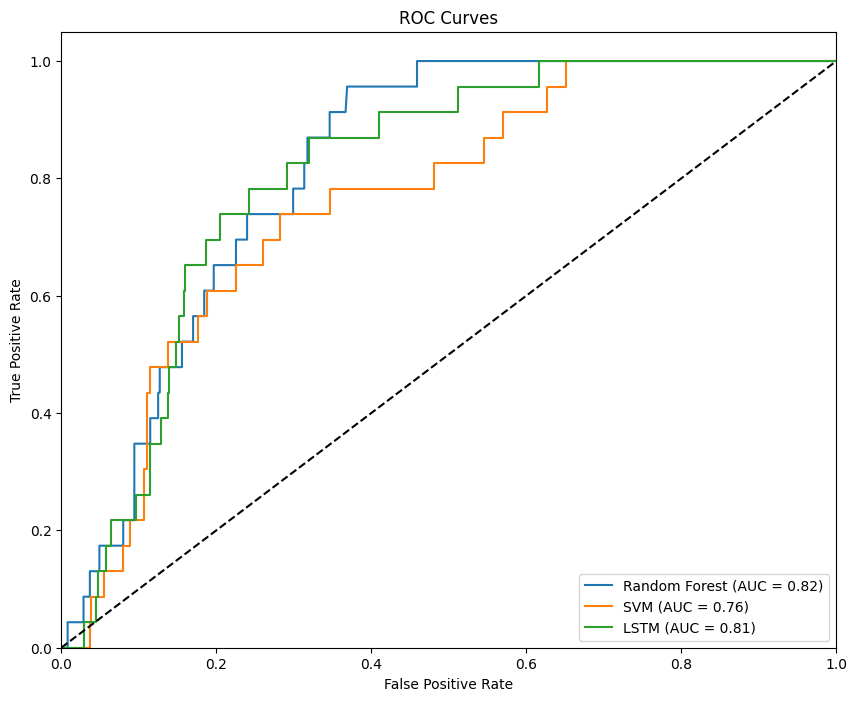

In [63]:
# Predict probabilities
rf_y_score = rf_classifier.predict_proba(X_test_scaled)[:, 1]
svm_y_score = svm_classifier.predict_proba(X_test_scaled)[:, 1]
lstm_y_score = lstm_model.predict(X_test_scaled_lstm).ravel()

# Compute ROC curve and ROC area for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_y_score)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_y_score)
auc_svm = auc(fpr_svm, tpr_svm)

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_y_score)
auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.2f)' % auc_svm)
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (AUC = %0.2f)' % auc_lstm)

plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()
